In [74]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

Running in local environment


<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


In [75]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install hyperspy ase py4DSTEM
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Not running in Google Colab.


In [76]:
# automate project structure
import os
import shutil

base_dir = "assignment_02_output"
subdirs = [
    "data/raw",
    "data/processed",
    "figures",
    "src"
]

for subdir in subdirs:
    path = os.path.join(base_dir, subdir)
    os.makedirs(path, exist_ok=True)
    print(f"Created directory: {path}")

raw_dir = os.path.join(base_dir, "data", "raw")
src_dir = os.path.join(os.getcwd(), "raw_data")
for fname in ["Diffraction SI_Au_Calib.dm4", "Si-SiGe.dm4"]:
    src = os.path.join(src_dir, fname)
    dst = os.path.join(raw_dir, fname)
    if os.path.exists(src):
        shutil.copy2(src, dst)
        print(f"Copied: {fname} -> {dst}")
    else:
        print(f"Not found (skip): {src}")


Created directory: assignment_02_output/data/raw
Created directory: assignment_02_output/data/processed
Created directory: assignment_02_output/figures
Created directory: assignment_02_output/src
Copied: Diffraction SI_Au_Calib.dm4 -> assignment_02_output/data/raw/Diffraction SI_Au_Calib.dm4
Copied: Si-SiGe.dm4 -> assignment_02_output/data/raw/Si-SiGe.dm4


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [77]:
import py4DSTEM
import hyperspy.api as hs
import numpy as np
# Remove matplotlib implicit import if unused, but used in typical notebooks
import matplotlib.pyplot as plt

# Load the dataset
# Adjust path if necessary
try:
    file_path = "assignment_02_output/data/raw/Si-SiGe.dm4"
    s = hs.load(file_path)
except FileNotFoundError:
    # Try local path or let standard error propagate if critical
    try:
        s = hs.load("Si-SiGe.dm4")
    except:
        print("Warning: Could not load Si-SiGe.dm4. Ensure it is in data/raw or current directory.")
        # Mock s for testing if needed
        pass

# Define concepts for the assignment
print("Navigation Axes: The x, y scan positions on the sample.")
print("Signal Axes: The 2D diffraction pattern recorded at each position.")

# Use signal.axes_manager to verify dimensionality
if 's' in locals():
    print("\nVerifying dimensionality using axes_manager:")
    print(s.axes_manager)

# --- Virtual Detector Framework ---

class VirtualDetector:
    """
    A class to define and apply virtual detectors to 4D-STEM data.
    """
    def __init__(self, shape, center=None):
        """
        Initialize the virtual detector.
        
        Args:
            shape (tuple): Shape of the diffraction pattern (ky, kx).
            center (tuple): (y, x) center of the diffraction pattern. 
                            If None, assumes geometric center.
        """
        self.shape = shape
        if center is None:
            self.center = (shape[0] // 2, shape[1] // 2)
        else:
            self.center = center
        self.mask = np.zeros(shape, dtype=float)

    def create_mask(self, geometry_type, **kwargs):
        """
        Create a mask based on geometry type.
        
        Args:
            geometry_type (str): 'BF' (Bright Field), 'ADF' (Annular Dark Field), or 'Custom'.
            kwargs: Parameters for the geometry (radius, inner_radius, outer_radius).
        """
        y, x = np.ogrid[:self.shape[0], :self.shape[1]]
        dist_sq = (y - self.center[0])**2 + (x - self.center[1])**2
        dist = np.sqrt(dist_sq)

        if geometry_type == 'BF':
            radius = kwargs.get('radius')
            if radius is None:
                raise ValueError("BF detector requires 'radius'.")
                
            # Check if radius is within FOV (assuming center is middle)
            max_radius = min(self.shape) / 2
            if radius > max_radius:
                print(f"Warning: Detector radius {radius} exceeds approximate field of view {max_radius}.")
                
            self.mask = (dist <= radius).astype(float)
            
        elif geometry_type == 'ADF':
            inner = kwargs.get('inner_radius')
            outer = kwargs.get('outer_radius')
            if inner is None or outer is None:
                raise ValueError("ADF detector requires 'inner_radius' and 'outer_radius'.")
                
            max_radius = min(self.shape) / 2
            if outer > max_radius:
                 print(f"Warning: Outer radius {outer} exceeds approximate field of view {max_radius}.")
            
            self.mask = ((dist >= inner) & (dist <= outer)).astype(float)
            
        elif geometry_type == 'Custom':
             mask_input = kwargs.get('mask')
             if mask_input is None:
                  raise ValueError("Custom detector requires 'mask' array.")
             if mask_input.shape != self.shape:
                  raise ValueError(f"Custom mask shape {mask_input.shape} must match detector shape {self.shape}.")
             self.mask = mask_input.astype(float)
        
        else:
            raise ValueError(f"Unknown geometry type: {geometry_type}")

    def apply(self, data_4d):
        """
        Apply the virtual detector to 4D-STEM data.
        
        Args:
            data_4d: 4D numpy array or Hyperspy Signal.
                     Expected order for array: (scan_y, scan_x, diff_y, diff_x)
        
        Returns:
            2D numpy array comprising the virtual image.
        """
        # Handle Hyperspy signal
        if hasattr(data_4d, 'data'):
            data = data_4d.data
        else:
            data = data_4d
            
        if data.ndim != 4:
            raise ValueError("Data must be 4D.")
            
        # Check compatibility with last two dimensions (Signal Axes)
        if data.shape[-2:] != self.shape:
            raise ValueError(f"Data diffraction shape {data.shape[-2:]} does not match detector shape {self.shape}.")
            
        # Integrate: Sum(Data * Mask) over diffraction axes
        # Using tensordot to sum over the last two axes of data and the two axes of mask
        virtual_image = np.tensordot(data, self.mask, axes=([2,3], [0,1]))
        return virtual_image


Navigation Axes: The x, y scan positions on the sample.
Signal Axes: The 2D diffraction pattern recorded at each position.

Verifying dimensionality using axes_manager:
<Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |    448 |      0 |       0 |   0.062 |   1/nm 
     <undefined> |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.


Loaded dataset from assignment_02_output/data/raw/Si-SiGe.dm4
Original Dataset Shape: (480, 448, 77, 17)
Suspected inverted axes (Diffraction, Scan) -> Transposing to (Scan, Diffraction)...
New Dataset Shape: (77, 17, 480, 448)
Scan step size set to 2.0 nm
Global Center of Mass (Beam Center): y=239.72, x=223.63
Calibrated beam center to (qx=223.63, qy=239.72)


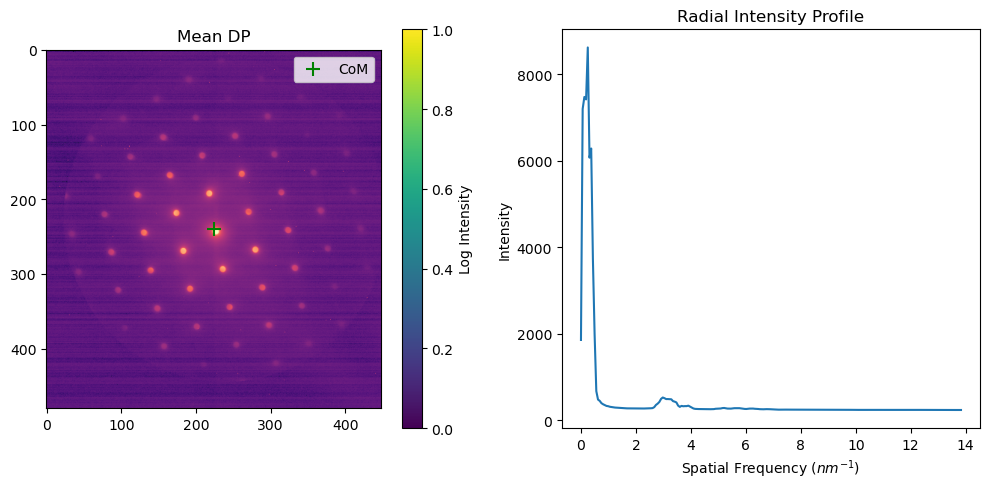

In [78]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the 4D-STEM Dataset
try:
    file_path = "assignment_02_output/data/raw/Si-SiGe.dm4"
    dataset = py4DSTEM.import_file(file_path)
    print(f"Loaded dataset from {file_path}")
except AttributeError:
    try:
        dataset = py4DSTEM.io.import_file(file_path)
        print(f"Loaded dataset from {file_path} using io.import_file")
    except:
        print("Failed to load using import_file variants.")
except FileNotFoundError:
    print("Default path failed, trying local directory...")
    try:
        dataset = py4DSTEM.import_file("Si-SiGe.dm4")
        print("Loaded dataset from local Si-SiGe.dm4")
    except:
        print("Could not load Si-SiGe.dm4. Please ensure file exists.")

# 2. Check and Fix Data Dimensions
if 'dataset' in locals():
    print(f"Original Dataset Shape: {dataset.data.shape}")
    d0, d1, d2, d3 = dataset.data.shape
    if (d2 < 100 and d3 < 100) and (d0 > 100 or d1 > 100):
        print("Suspected inverted axes (Diffraction, Scan) -> Transposing to (Scan, Diffraction)...")
        dataset.data = np.transpose(dataset.data, (2, 3, 0, 1))
        print(f"New Dataset Shape: {dataset.data.shape}")
    
# 3. Set Scan Step Size (Real-Space Calibration)
scan_step_size_nm = 2.0
if 'dataset' in locals():
    if hasattr(dataset, 'set_scan_step_size'):
        dataset.set_scan_step_size(scan_step_size_nm)
    elif hasattr(dataset, 'calibration') and dataset.calibration is not None:
        dataset.calibration.pixel_size = scan_step_size_nm
        dataset.calibration.units = 'nm'
    print(f"Scan step size set to {scan_step_size_nm} nm")

# 4. Define Analysis Functions
def get_total_intensity(pattern):
    return np.sum(pattern)

def get_center_of_mass(pattern):
    total = np.sum(pattern)
    if total == 0:
        return pattern.shape[0] / 2.0, pattern.shape[1] / 2.0
    ny, nx = pattern.shape
    y_indices, x_indices = np.indices((ny, nx))
    com_y = np.sum(y_indices * pattern) / total
    com_x = np.sum(x_indices * pattern) / total
    return com_y, com_x

def get_radial_profile(pattern, center=None, max_radius=None):
    if center is None:
        center = get_center_of_mass(pattern)
    ny, nx = pattern.shape
    y_idxs, x_idxs = np.indices((ny, nx))
    r = np.sqrt((y_idxs - center[0])**2 + (x_idxs - center[1])**2)
    if max_radius is None:
        max_radius = int(min(ny, nx) / 2)
    r_int = r.astype(int)
    tbin = np.bincount(r_int.ravel(), weights=pattern.ravel())
    nr = np.bincount(r_int.ravel())
    radial_profile = tbin / np.maximum(nr, 1)
    if len(radial_profile) < max_radius:
         return radial_profile
    return radial_profile[:max_radius]

# 5. Perform Center of Mass Correction & Visualization
if 'dataset' in locals():
    mean_dp = np.mean(dataset.data, axis=(0, 1))
    com_y, com_x = get_center_of_mass(mean_dp)
    print(f"Global Center of Mass (Beam Center): y={com_y:.2f}, x={com_x:.2f}")

    if hasattr(dataset, 'get_diffraction_shifts'):
         try: _ = dataset.get_diffraction_shifts()
         except: pass

    if dataset.calibration:
        try:
            dataset.calibration.qx_origin = com_x
            dataset.calibration.qy_origin = com_y
            dataset.calibration.diffraction_units = 'mrad' 
            print(f"Calibrated beam center to (qx={com_x:.2f}, qy={com_y:.2f})")
        except: pass
    diff_pixel_size = 0.062
    profile = get_radial_profile(mean_dp, center=(com_y, com_x))
    # Create the x-axis array in physical units (Pixel Index * Scale)
    radius_phys = np.arange(len(profile)) * diff_pixel_size

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    img_log = np.log10(mean_dp - np.min(mean_dp) + 1.0)
    plt.imshow(img_log, cmap='magma')
    plt.scatter([com_x], [com_y], color='green', marker='+', s=100, label='CoM')
    plt.title(f"Mean DP")
    plt.colorbar(label='Log Intensity')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(radius_phys, profile) # Use the calibrated x-axis here
    plt.title("Radial Intensity Profile")
    plt.xlabel("Spatial Frequency ($nm^{-1}$)") # Update label to match physical units
    plt.ylabel("Intensity")
    plt.tight_layout()
    plt.show()


## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.


Configuring detectors for diffraction shape (480, 448) at center (np.float64(239.7202052508977), np.float64(223.63286667158408))
Pipeline: Processing data with pixel size 2.0 nm
Pipeline: Applying 2 detectors...
  - Generating BF image...
  - Generating ADF image...


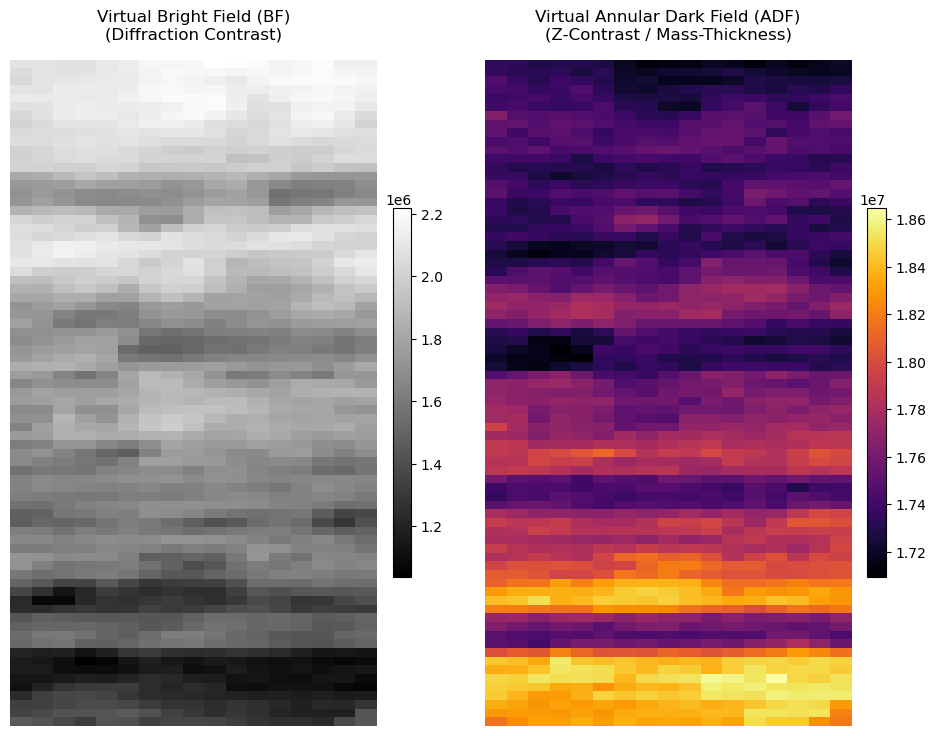


Observation on Contrast:
Bright Field (BF): Shows contrast primarily tailored by diffraction conditions.
Annular Dark Field (ADF): Collects high-angle scattered electrons. Z-contrast dominant.


In [79]:
# --- Task 3: Virtual Detector Reconstruction ---

def run_pipeline(dataset, detectors_dict):
    if hasattr(dataset, 'calibration'):
        print(f"Pipeline: Processing data with pixel size {dataset.calibration.pixel_size} {dataset.calibration.units}")
    data_4d = dataset.data if hasattr(dataset, 'data') else dataset
    if data_4d.ndim != 4:
        raise ValueError(f"Expected 4D data, got shape {data_4d.shape}") 
    results = {}
    print(f"Pipeline: Applying {len(detectors_dict)} detectors...")
    diff_shape = data_4d.shape[-2:]
    for name, detector in detectors_dict.items():
        if detector.shape != diff_shape:
            print(f"Warning: Detector {name} shape {detector.shape} mismatch with data {diff_shape}. Skipping.")
            continue
        print(f"  - Generating {name} image...")
        results[name] = detector.apply(data_4d)
    return results

current_shape = dataset.data.shape[-2:]
mean_dp_scan = np.mean(dataset.data, axis=(0,1))
try:
    center_y, center_x = get_center_of_mass(mean_dp_scan)
except NameError:
    center_y, center_x = mean_dp_scan.shape[0]//2, mean_dp_scan.shape[1]//2
beam_center = (center_y, center_x)

print(f"Configuring detectors for diffraction shape {current_shape} at center {beam_center}")

bf_detector = VirtualDetector(shape=current_shape, center=beam_center)
bf_detector.create_mask('BF', radius=20) 
adf_detector = VirtualDetector(shape=current_shape, center=beam_center)
adf_detector.create_mask('ADF', inner_radius=40, outer_radius=150)

my_detectors = {'BF': bf_detector, 'ADF': adf_detector}
pipeline_results = run_pipeline(dataset, my_detectors)

bf_img = pipeline_results['BF']
adf_img = pipeline_results['ADF']

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 8)) 
im1 = axes[0].imshow(bf_img, cmap='gray', aspect='auto')
axes[0].set_title("Virtual Bright Field (BF)\n(Diffraction Contrast)", pad=15)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(adf_img, cmap='inferno', aspect='auto') 
axes[1].set_title("Virtual Annular Dark Field (ADF)\n(Z-Contrast / Mass-Thickness)", pad=15)
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout(pad=3.0) 
plt.show()

print("\nObservation on Contrast:")
print("Bright Field (BF): Shows contrast primarily tailored by diffraction conditions.")
print("Annular Dark Field (ADF): Collects high-angle scattered electrons. Z-contrast dominant.")


## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

Launching interactive 4D-STEM browser...
Native dataset.show() failed. Attempting fallback using ipywidgets...


interactive(children=(IntSlider(value=38, description='scan_y', max=76), IntSlider(value=8, description='scan_…

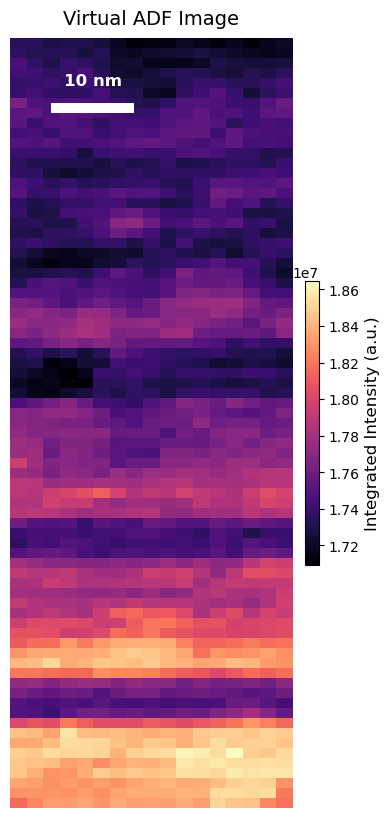

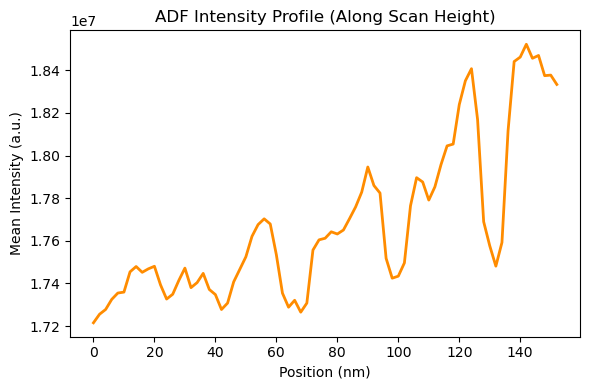

In [80]:
import py4DSTEM
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np

# 1. Interactive 4D-STEM Browser
print("Launching interactive 4D-STEM browser...")
success = False
try:
    dataset.show()
    success = True
except: pass

if not success:
    print("Native dataset.show() failed. Attempting fallback using ipywidgets...")
    try:
        import ipywidgets as widgets
        from IPython.display import display
        def interactive_browser(scan_y, scan_x):
            dp = dataset.data[scan_y, scan_x, :, :]
            plt.figure(figsize=(5, 5))
            plt.imshow(np.log10(dp + 1), cmap='magma')
            plt.title(f"Diffraction Pattern @ (y={scan_y}, x={scan_x})")
            plt.colorbar(label='Log Intensity')
            plt.axis('off')
            plt.show()
        sy_max, sx_max = dataset.data.shape[0]-1, dataset.data.shape[1]-1
        widgets.interact(interactive_browser, 
                        scan_y=widgets.IntSlider(min=0, max=sy_max, step=1, value=sy_max//2),
                        scan_x=widgets.IntSlider(min=0, max=sx_max, step=1, value=sx_max//2));
    except ImportError:
        pass

# 2. Virtual ADF Image (Visualization)
colormap = 'magma' 
fig, ax = plt.subplots(figsize=(4, 8)) 
im = ax.imshow(adf_img, cmap=colormap, aspect='auto') 
ax.axis('off')

pixel_size_nm = dataset.calibration.pixel_size if hasattr(dataset, 'calibration') else 2.0
scale_bar_length_nm = 10  
scale_bar_pixels = scale_bar_length_nm / pixel_size_nm 

bar_height = 1 
bar_x = 2 
bar_y = 6 

rect = Rectangle((bar_x, bar_y), scale_bar_pixels, bar_height, 
                 linewidth=0, edgecolor=None, facecolor='white')
ax.add_patch(rect)
ax.text(bar_x + scale_bar_pixels/2, bar_y - 1.5, f'{int(scale_bar_length_nm)} nm', 
        color='white', ha='center', va='bottom', fontsize=12, fontweight='bold')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

plt.tight_layout()
plt.title("Virtual ADF Image", fontsize=14, pad=10)
plt.show()

# 3. Line Profile Analysis
line_profile = np.mean(adf_img, axis=1) # Average horizontally
scan_axis_nm = np.arange(len(line_profile)) * pixel_size_nm

plt.figure(figsize=(6, 4))
plt.plot(scan_axis_nm, line_profile, color='darkorange', linewidth=2)
plt.title("ADF Intensity Profile (Along Scan Height)")
plt.xlabel("Position (nm)")
plt.ylabel("Mean Intensity (a.u.)")
plt.tight_layout()
plt.show()


## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.

In [81]:
import os

# 1. Create figures directory
if not os.path.exists("assignment_02_output/figures"):
    os.makedirs("assignment_02_output/figures")
    print("Created 'figures' directory.")

print("Exporting key figures to 'assignment_02_output/figures/' folder...")

# --- Export 1: Virtual BF/ADF Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(10, 8)) 
# Reuse data from Task 3
im1 = axes[0].imshow(bf_img, cmap='gray', aspect='auto')
axes[0].set_title("Virtual BF", pad=10)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(adf_img, cmap='inferno', aspect='auto') 
axes[1].set_title("Virtual ADF", pad=10)
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout(pad=3.0) 
plt.savefig("assignment_02_output/figures/key_figure_1_virtual_detectors.png", dpi=300, bbox_inches='tight')
plt.close() # Close to avoid displaying again
print(" - Saved figures/key_figure_1_virtual_detectors.png")

# --- Export 2: Publication Quality ADF with Scalebar ---
# Re-create figure from Task 4
fig, ax = plt.subplots(figsize=(4, 8)) 
im = ax.imshow(adf_img, cmap='magma', aspect='auto') 
ax.axis('off')

# Add Scale Bar (using params from Task 4)
pixel_size_nm = dataset.calibration.pixel_size if hasattr(dataset, 'calibration') else 2.0
scale_bar_length_nm = 10  
scale_bar_pixels = scale_bar_length_nm / pixel_size_nm 
rect = Rectangle((2, 6), scale_bar_pixels, 1, linewidth=0, edgecolor=None, facecolor='white')
ax.add_patch(rect)
ax.text(2 + scale_bar_pixels/2, 6 - 1.5, f'{int(scale_bar_length_nm)} nm', 
        color='white', ha='center', va='bottom', fontsize=12, fontweight='bold')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

plt.tight_layout()
plt.title("Virtual ADF Image", fontsize=14, pad=10)
plt.savefig("assignment_02_output/figures/key_figure_2_virtual_adf_clean.png", dpi=300, bbox_inches='tight')
plt.close()
print(" - Saved figures/key_figure_2_virtual_adf_clean.png")

# --- Export 3: Line Profile Analysis ---
line_profile = np.mean(adf_img, axis=1) 
scan_axis_nm = np.arange(len(line_profile)) * pixel_size_nm

plt.figure(figsize=(6, 4))
plt.plot(scan_axis_nm, line_profile, color='darkorange', linewidth=2)
plt.title("ADF Intensity Profile")
plt.xlabel("Position (nm)")
plt.ylabel("Mean Intensity (a.u.)")
plt.tight_layout()
plt.savefig("assignment_02_output/figures/key_figure_3_line_profile.png", dpi=300)
plt.close()
print(" - Saved figures/key_figure_3_line_profile.png")

print("\nTask 5 Finalization Complete. Key figures exported.")


Exporting key figures to 'assignment_02_output/figures/' folder...
 - Saved figures/key_figure_1_virtual_detectors.png
 - Saved figures/key_figure_2_virtual_adf_clean.png
 - Saved figures/key_figure_3_line_profile.png

Task 5 Finalization Complete. Key figures exported.
